In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
n_samples = 100
n_step = 500
n_dim = 2
device = 'cuda:0'

## Forward process

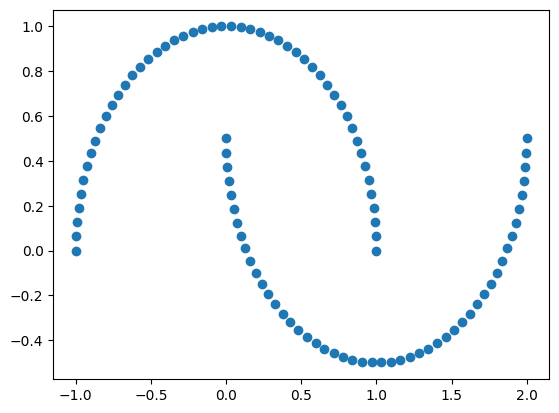

In [ ]:
from sklearn.datasets import make_moons
x0, y = make_moons(n_samples)
x0 = torch.from_numpy(x0)
plt.scatter(x0[:,0], x0[:,1]) ## x and y coordinate of x0,
plt.show()

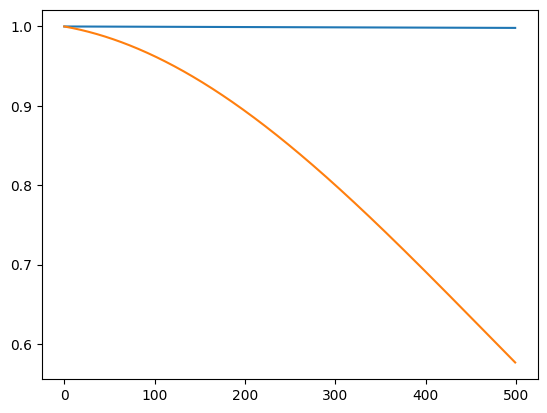

In [ ]:
beta_start = 0.0001
beta_end = 0.001
scale = 1000 / n_step # T = 1000 ->. scale = 1

betas = torch.linspace(beta_start*scale, beta_end*scale, n_step)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0) # alpha_bar

plt.plot(alphas) #blue
plt.plot(alphas_cumprod) #orange
plt.show()

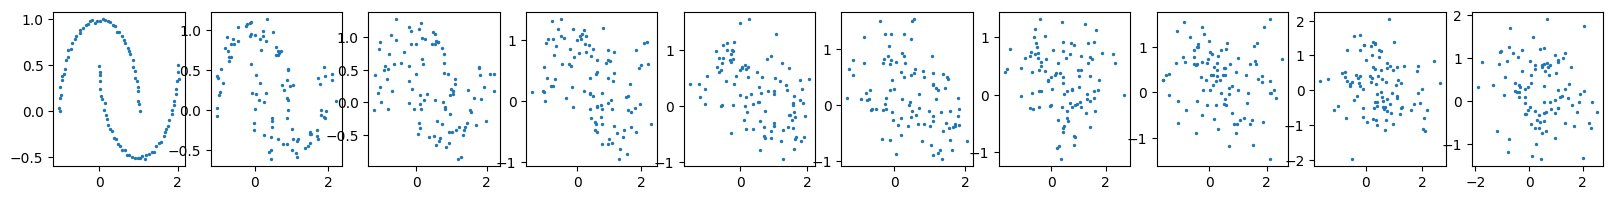

In [ ]:
def p_t_single(x0, t):
    noise = torch.randn_like(x0) #normal distribution with zero mean and unit variase, the dimension is the same as x0
    return torch.sqrt(alphas_cumprod[t]) * x0 + torch.sqrt(1-alphas_cumprod[t]) * noise

fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i, t in enumerate(range(0, n_step, n_step//10)):
    xt = p_t_single(x0, t)
    axs[i].scatter(xt[:,0], xt[:,1], s=2, alpha=1)
plt.show()

In [ ]:
def extract(alphas, t, x_shape):
    b = t.shape[0]
    out = alphas.gather(-1, t) # alphas의 t번쨰 index를 가져와서 새로운 tensor로 만들어줌
    return out.reshape(b, 1)

def p_t(x0, t, noise=None):
    # return x_t, e_t
    noise = torch.randn_like(x0) if noise is None else noise # epsilon
    return extract(alphas_cumprod.sqrt(), t, x0.shape) * x0 + extract((1-alphas_cumprod).sqrt(), t, x0.shape) * noise, noise

## Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_dim=2, n_hidden=[256]):
        super().__init__() # nn.Module으로 기능할 수 있게됨
        self.t_emb = nn.Sequential(
            nn.Embedding(n_step, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.GELU()
        )
        self.x_emb = nn.Sequential(
            nn.Linear(n_dim, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.GELU()
        )
        self.fc = nn.Sequential(
            nn.Linear(n_hidden, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_dim)
        )

    def forward(self, xt, t):
        xt = self.x_emb(xt)
        t = self.t_emb(t)
        return self.fc(xt + t)

## Train

In [ ]:
model = MLP(n_dim=2, n_hidden=256).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

x0 = x0.to(device=device, dtype=torch.float)
betas = betas.to(device=device, dtype=torch.float)
alphas = alphas.to(device=device, dtype=torch.float)
alphas_cumprod = alphas_cumprod.to(device=device, dtype=torch.float)

In [ ]:
loss_history = []
model.train()
for n in tqdm(range(100000)):
    optim.zero_grad()
    t = torch.randint(0, n_step, (n_samples, ), device=device)
    noise = torch.randn_like(x0)

    xt, noise = p_t(x0, t, noise)
    noise_pred = model(xt, t)

    loss = (noise - noise_pred).square().mean()
    loss.backward()
    optim.step()
    loss_history.append(loss.item())

 47%|████▋     | 47246/100000 [05:43<06:23, 137.59it/s]


KeyboardInterrupt: 

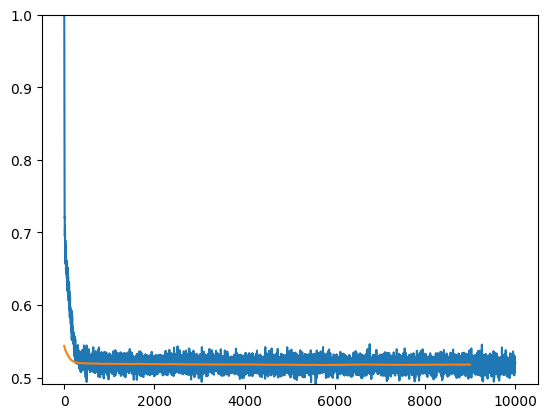

In [ ]:
plt.plot(loss_history)
plt.plot(np.convolve(loss_history, np.ones(1000)/1000, mode='valid'))
plt.ylim(min(loss_history), 1)
plt.show()

## Sample

In [ ]:
n_eval = 1000

def set_timesteps(n_eval):
    t_max = n_step - 1
    seq = torch.linspace(0, 1, n_eval) * t_max
    seq_prev = torch.cat([torch.tensor([-1]), seq[:-1]], dim=0)
    timesteps = reversed(seq[1:])
    timesteps_prev = reversed(seq_prev[1:])
    return timesteps, timesteps_prev

@torch.no_grad()
def ddim_step(xt, et, t_idx, eta):
    b = xt.shape[0]
    t = timesteps[t_idx]
    t_prev = timesteps_prev[t_idx]

    batched_t = torch.full((b,), t, device=device, dtype=torch.long)
    batched_t_prev = torch.full((b,), t_prev, device=device, dtype=torch.long)

    at = extract(alphas_cumprod, batched_t, xt.shape)
    at_prev = extract(alphas_cumprod, batched_t_prev, xt.shape)

    x0_pred = (xt - et*(1-at).sqrt()) / at.sqrt()
    sigma_t = ((1-at_prev)/(1-at)*(1-(at/at_prev))).sqrt() * eta
    xt_prev = at_prev.sqrt()*x0_pred + (1-at_prev-sigma_t.square()).sqrt()*et + sigma_t*torch.randn_like(xt)
    return xt_prev

In [ ]:
n_eval = 1000
xt = torch.randn_like(x0)
#xt = torch.randn(10000, 2).to(device)
xt_traj = [xt.detach().cpu()]
timesteps, timesteps_prev = set_timesteps(n_eval)

for i, t in enumerate(timesteps):
    t = t.to(device=device, dtype=torch.long)
    noise_pred = model(xt, torch.full((xt.shape[0],), t, device=device, dtype=torch.long))
    xt = ddim_step(xt, noise_pred, i, eta=1) # when eta=1 DDPM, eta=0 DDIM
    xt_traj.append(xt.detach().cpu())

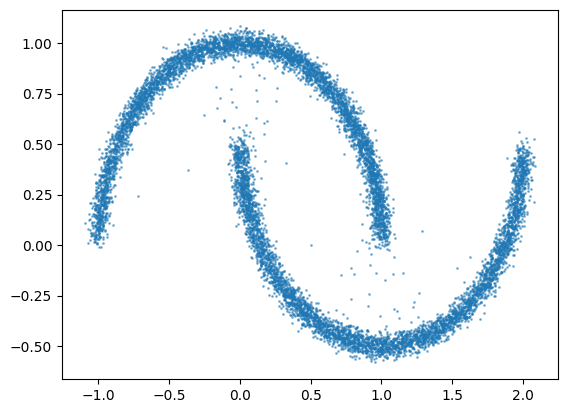

In [ ]:
plt.scatter(xt_traj[-1][:,0], xt_traj[-1][:,1], s=1, alpha=0.5)
plt.show()

In [ ]:
n_eval = 1000
xt = torch.randn_like(x0)
#xt = torch.randn(10000, 2).to(device)
xt_traj = [xt.detach().cpu()]
timesteps, timesteps_prev = set_timesteps(n_eval)

for i, t in enumerate(timesteps):
    t = t.to(device=device, dtype=torch.long)
    noise_pred = model(xt, torch.full((xt.shape[0],), t, device=device, dtype=torch.long))
    xt = ddim_step(xt, noise_pred, i, eta=0) # when eta=1 DDPM, eta=0 DDIM
    xt_traj.append(xt.detach().cpu())

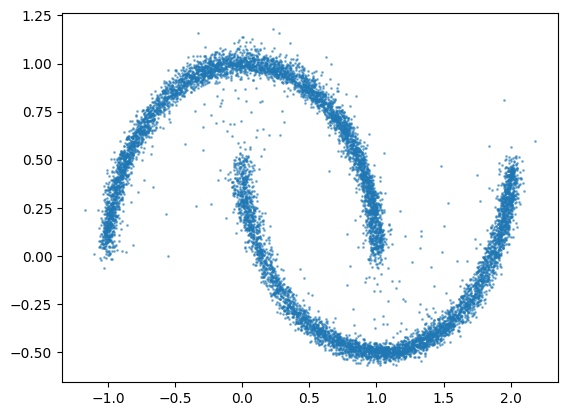

In [ ]:
plt.scatter(xt_traj[-1][:,0], xt_traj[-1][:,1], s=1, alpha=0.5)
plt.show()

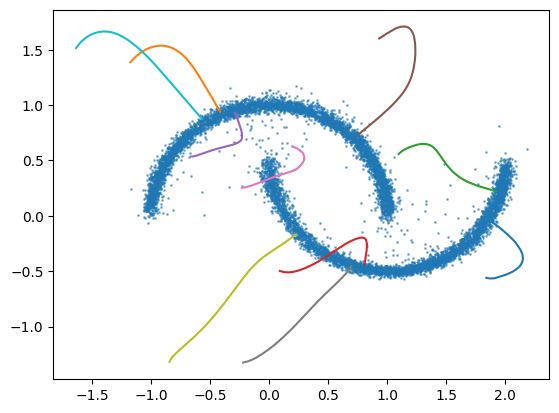

In [ ]:
x_traj = torch.stack(xt_traj)
plt.plot(x_traj[:,:10,0], x_traj[:,:10,1])
plt.scatter(xt_traj[-1][:,0], xt_traj[-1][:,1], s=1, alpha=0.5)
plt.show()